# Count data with negative binomial model

Many timeseries are composed of counts, which are non-negative integers. For example, the number of cars that pass through a toll booth in a given hour, the number of people who visit a website in a given day, or the number of sales of a product. The original Prophet model struggles to handle this type of data, as it assumes that the data is continuous and normally distributed. In this tutorial, we will show you how to use the `prophetverse` library to model count data, with a prophet-like model that uses Negative Binomial likelihood.

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

We use a dataset `Melbourne Pedestrian Counts` from [forecastingdata](forecastingdata.com), which contains the hourly pedestrian counts in Melbourne, Australia, from a set of sensors located in different parts of the city. 

In [2]:
from sktime.datasets import load_forecastingdata


def _parse_data(df):

    dfs = []
    # iterrows
    for index, row in df.iterrows():

        _df = pd.DataFrame(
            data={
                "pedestrian_count": row["series_value"],
                "date": pd.period_range(
                    row["start_timestamp"], periods=len(row["series_value"]), freq="H"
                ),
            },
        )
        _df["series_name"] = row["series_name"]
        dfs.append(_df)

    return pd.concat(dfs).set_index(["series_name", "date"])


def load_dataset():
    df, _ = load_forecastingdata("pedestrian_counts_dataset")
    return _parse_data(df)


y = load_dataset()

# We take only one time series for simplicity
y = y.loc["T2"]

split_index = 24*365
y_train, y_test = y.iloc[:split_index], y.iloc[split_index+1:split_index*2+1]

In [3]:
y_train.head()

,pedestrian_count
date,
2009-05-01 00:00,52.0
2009-05-01 01:00,34.0
2009-05-01 02:00,19.0
2009-05-01 03:00,14.0
2009-05-01 04:00,15.0


<Axes: xlabel='date'>

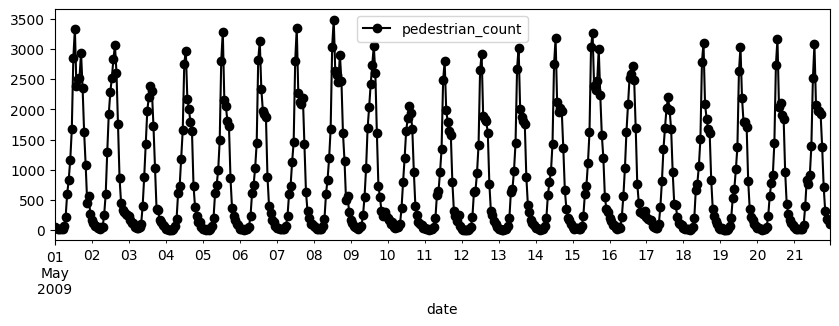

In [4]:
y_train.iloc[:24*21].plot(figsize=(10, 3), marker="o", color="black", legend=True)

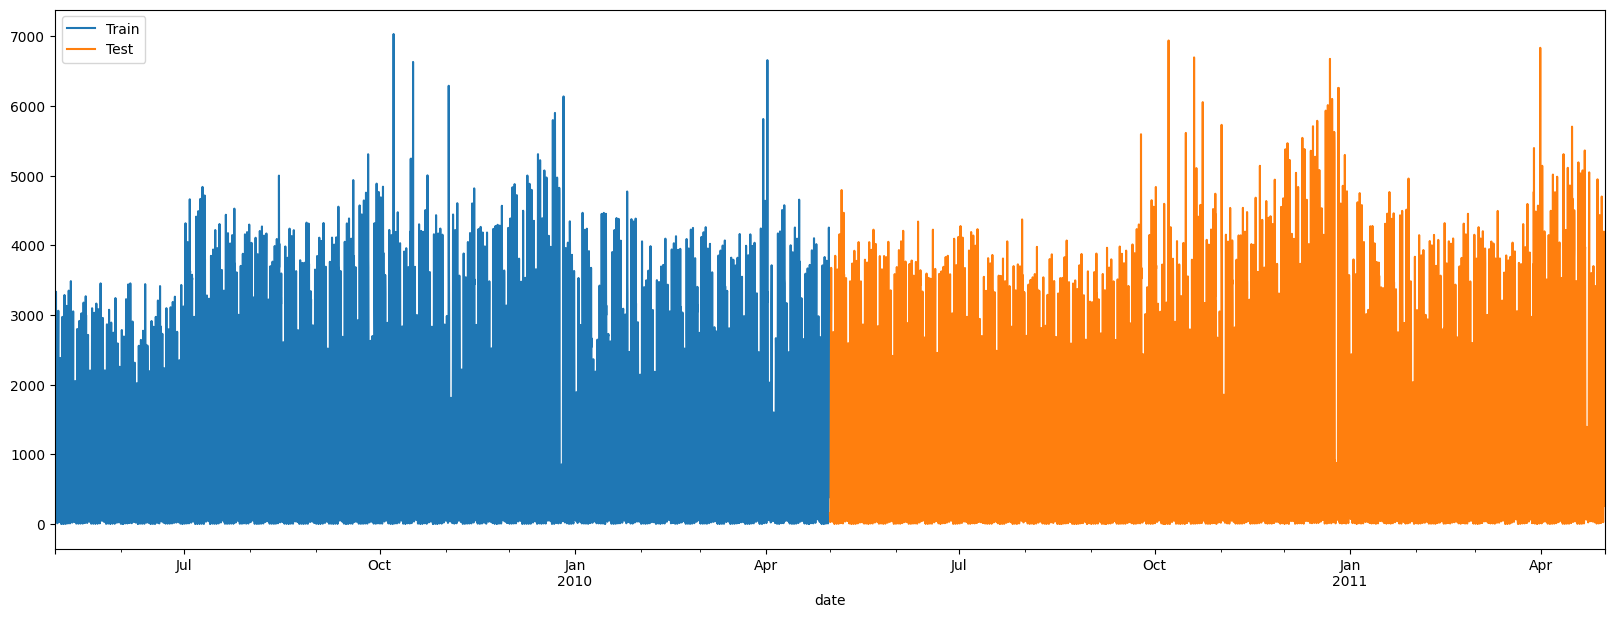

In [5]:
ax = y_train["pedestrian_count"].rename("Train").plot(figsize=(20,7))
y_test["pedestrian_count"].rename("Test").plot(ax=ax)
ax.legend()
plt.show()

# Fitting models

The series has some clear patterns: a daily seasonality, a weekly seasonality, and a yearly seasonality. It also has many zeros, and a model assuming normal distributed observations would not be able to capture this. First, let's the normal-likelihood one, then see how the negative binomial model performs.

## Prophet with normal likelihood (bad for count data)


In [6]:
from prophetverse.sktime import Prophet
from prophetverse.sktime.seasonality import seasonal_transformer
from prophetverse.effects import LinearEffect
from prophetverse.utils.regex import starts_with
from sktime.transformations.series.fourier import FourierFeatures


# We specify the seasonality with Fourier features
seasonal_features = FourierFeatures(
    sp_list=[24, 24 * 7, 24 * 365.5],
    fourier_terms_list=[2, 2, 10],
    freq="H",
    keep_original_columns=True,
)

# Here we set the prior for the seasonality effect
# And the coefficients for it
exogenous_effects = [
    LinearEffect(
        id="seasonality",
        prior=(dist.Normal, 0, 0.5),
        effect_mode="multiplicative",
        regex=starts_with(["sin", "cos"]),
    )
]

model = Prophet(
    trend="flat",
    changepoint_interval=300,
    changepoint_prior_scale=0.001,
    feature_transformer=seasonal_features,
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=20000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.001},
    inference_method="map",
    mcmc_warmup=500,
    mcmc_samples=2000,
)
model.fit(y=y_train)

100%|██████████| 20000/20000 [00:02<00:00, 7589.42it/s, init loss: 28421.7793, avg. loss [19001-20000]: -11899.9804]


Prophet(changepoint_interval=300,
        exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x16e80cbd0>],
        feature_transformer=FourierFeatures(fourier_terms_list=[2, 2, 10],
                                            freq='H',
                                            keep_original_columns=True,
                                            sp_list=[24, 168, 8772.0]),
        mcmc_warmup=500, optimizer_kwargs={'step_size': 0.001},
        optimizer_steps=20000, trend='flat')

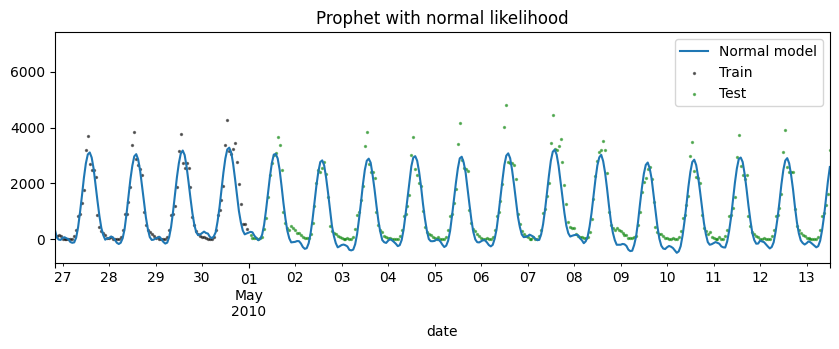

In [7]:
forecast_horizon = y_train.index[-100:].union(y_test.index[:300])
fig, ax = plt.subplots(figsize=(10, 3))
preds_normal = model.predict(fh=forecast_horizon)
preds_normal["pedestrian_count"].rename("Normal model").plot.line(
    ax=ax, legend=False, color="tab:blue"
)
ax.scatter(y_train.index, y_train, marker="o", color="k", s=2, alpha=0.5, label="Train")
ax.scatter(y_test.index, y_test, marker="o", color="green", s=2, alpha=0.5, label="Test")
ax.set_title("Prophet with normal likelihood")
ax.legend()
fig.show()

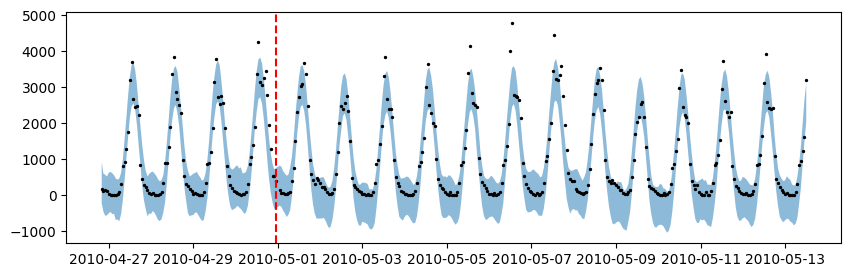

In [8]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 3))
# Plot area between quantiles
ax.fill_between(quantiles.index.to_timestamp(), quantiles.iloc[:, 0], quantiles.iloc[:, -1], alpha=0.5)
ax.scatter(forecast_horizon.to_timestamp(), y.loc[forecast_horizon], marker="o", color="k", s=2, alpha=1)
ax.axvline(y_train.index[-1].to_timestamp(), color="r", linestyle="--")
fig.show()


The model forecasts some negative values - which don't make sense! Damn you, normal distribution!

## Prophet with negative binomial likelihood

In [9]:
from prophetverse.sktime import ProphetNegBinomial

model = ProphetNegBinomial(
    trend="flat",
    changepoint_interval=300,
    changepoint_prior_scale=0.001,
    feature_transformer=seasonal_features,
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=20000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.001},
    inference_method="map",
    mcmc_warmup=500,
    mcmc_samples=2000,
)
model.fit(y=y_train)

100%|██████████| 20000/20000 [00:18<00:00, 1062.00it/s, init loss: 27705970.0000, avg. loss [19001-20000]: 59806.3395]


ProphetNegBinomial(changepoint_interval=300,
                   exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x16e80cbd0>],
                   feature_transformer=FourierFeatures(fourier_terms_list=[2, 2,
                                                                           10],
                                                       freq='H',
                                                       keep_original_columns=True,
                                                       sp_list=[24, 168,
                                                                8772.0]),
                   mcmc_warmup=500, optimizer_kwargs={'step_size': 0.001},
                   optimizer_steps=20000, trend='flat')

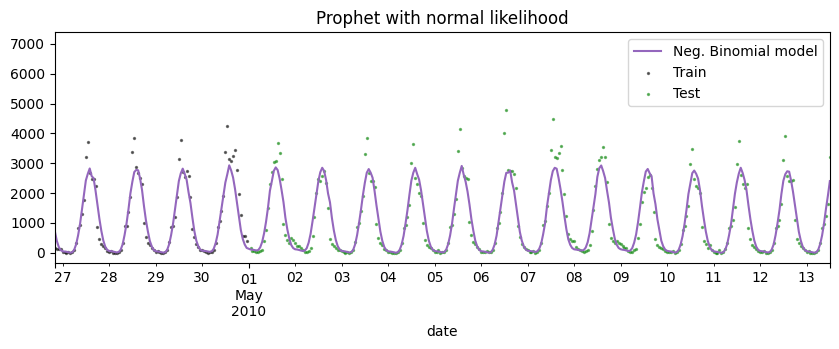

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
preds_negbin = model.predict(fh=forecast_horizon)
preds_negbin["pedestrian_count"].rename("Neg. Binomial model").plot.line(
    ax=ax, legend=False, color="tab:purple"
)
ax.scatter(y_train.index, y_train, marker="o", color="k", s=2, alpha=0.5, label="Train")
ax.scatter(
    y_test.index, y_test, marker="o", color="green", s=2, alpha=0.5, label="Test"
)
ax.set_title("Prophet with normal likelihood")
ax.legend()
fig.show()

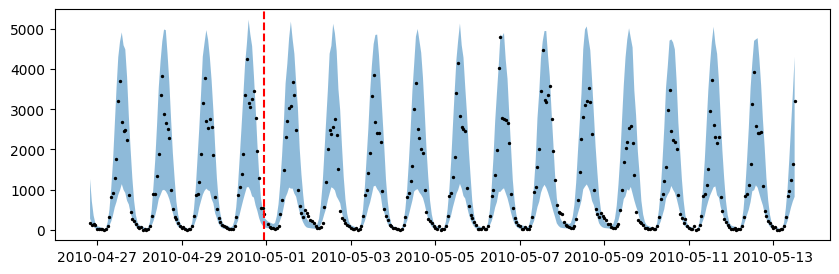

In [11]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 3))
# Plot area between quantiles
ax.fill_between(
    quantiles.index.to_timestamp(),
    quantiles.iloc[:, 0],
    quantiles.iloc[:, -1],
    alpha=0.5,
)
ax.scatter(
    forecast_horizon.to_timestamp(),
    y.loc[forecast_horizon],
    marker="o",
    color="k",
    s=2,
    alpha=1,
)
ax.axvline(y_train.index[-1].to_timestamp(), color="r", linestyle="--")
fig.show()

### Comparing both forecasts side by side

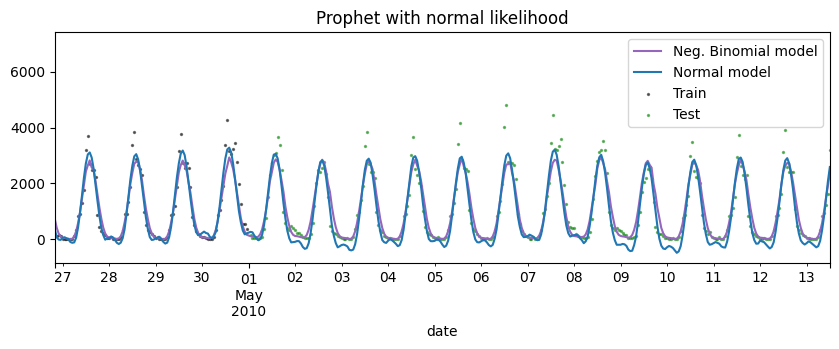

In [12]:
fig, ax = plt.subplots(figsize=(10, 3))
preds_negbin["pedestrian_count"].rename("Neg. Binomial model").plot.line(
    ax=ax, legend=False, color="tab:purple"
)
preds_normal["pedestrian_count"].rename("Normal model").plot.line(
    ax=ax, legend=False, color="tab:blue"
)
ax.scatter(y_train.index, y_train, marker="o", color="k", s=2, alpha=0.5, label="Train")
ax.scatter(
    y_test.index, y_test, marker="o", color="green", s=2, alpha=0.5, label="Test"
)
ax.set_title("Prophet with normal likelihood")
ax.legend()
fig.show()